Импорты стандартных библиотек

In [36]:
import os
import re
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import img_to_array

In [37]:
SIZE = 256

In [38]:
def sorted_alphanumeric(data):
    """
    Сортирует список файлов в алфавитно-числовом порядке.
    """
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

def load_images_from_folder(path, size):
    """
    Загружает и обрабатывает изображения из указанной папки.
    """
    images = []
    files = os.listdir(path)
    files = sorted_alphanumeric(files)
    
    for file_name in tqdm(files, desc=f"Загрузка изображений из {path}"):
        file_path = os.path.join(path, file_name)
        
        if file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            img = cv2.imread(file_path, cv2.IMREAD_COLOR)
            
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (size, size))
                img = img.astype('float32') / 255.0
                images.append(img_to_array(img))
            else:
                print(f"Предупреждение: Не удалось загрузить изображение {file_path}")
    
    return images

high_res_path = '../input/image-super-resolution/dataset/Raw Data/high_res'
low_res_path = '../input/image-super-resolution/dataset/Raw Data/low_res'

high_img = load_images_from_folder(high_res_path, SIZE)
low_img = load_images_from_folder(low_res_path, SIZE)

print(f"Количество изображений высокого разрешения: {len(high_img)}")
print(f"Количество изображений низкого разрешения: {len(low_img)}")

Загрузка изображений из ../input/image-super-resolution/dataset/Raw Data/high_res: 100%|██████████| 855/855 [00:04<00:00, 201.91it/s]
Загрузка изображений из ../input/image-super-resolution/dataset/Raw Data/low_res: 100%|██████████| 855/855 [00:03<00:00, 227.95it/s]

Количество изображений высокого разрешения: 855
Количество изображений низкого разрешения: 855


Визуализируем пары изображений высокого и низкого разрешения из соответствующих списков high_img и low_img

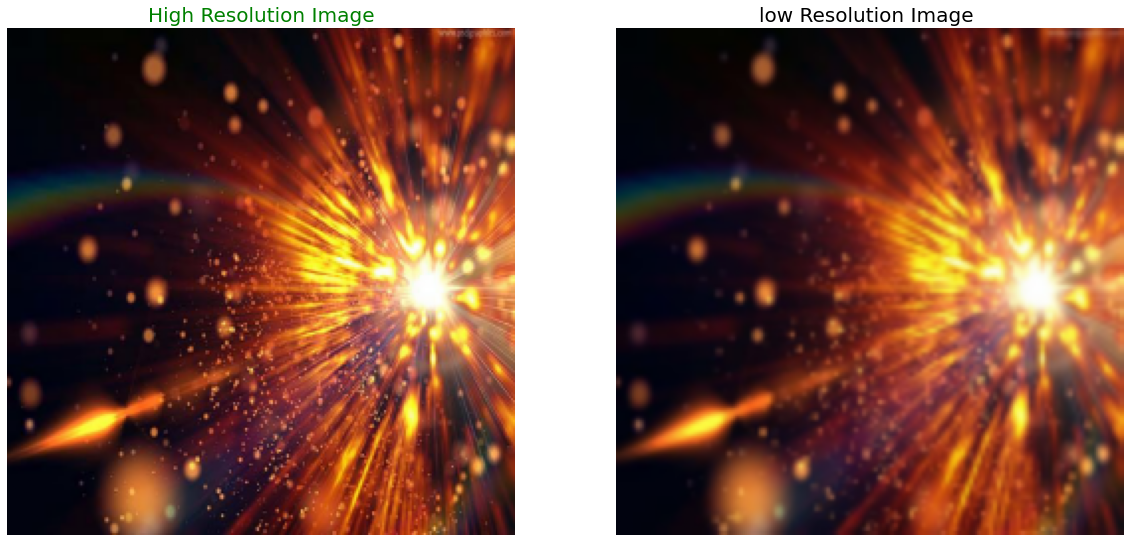

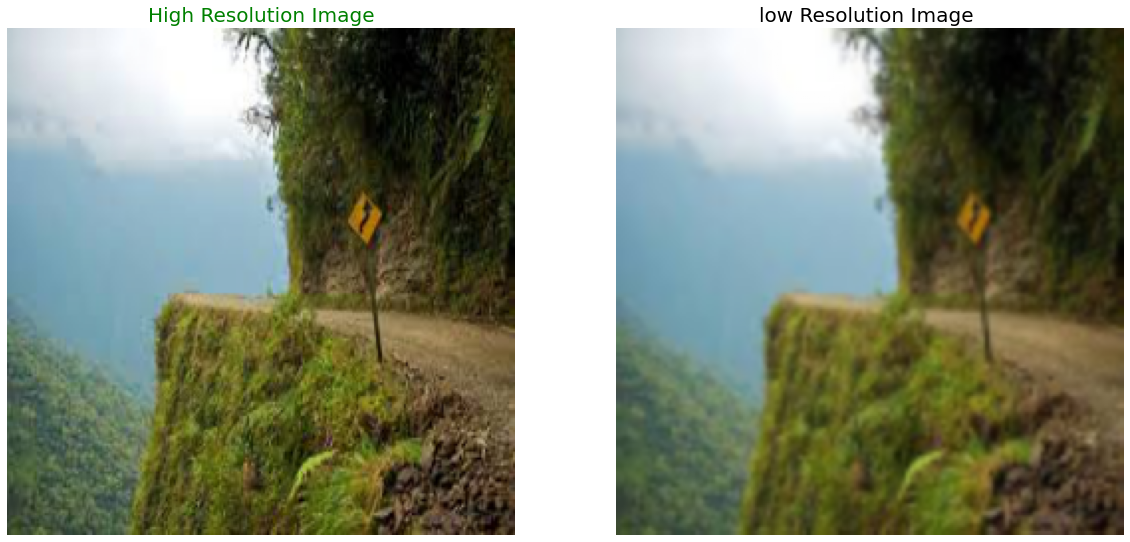

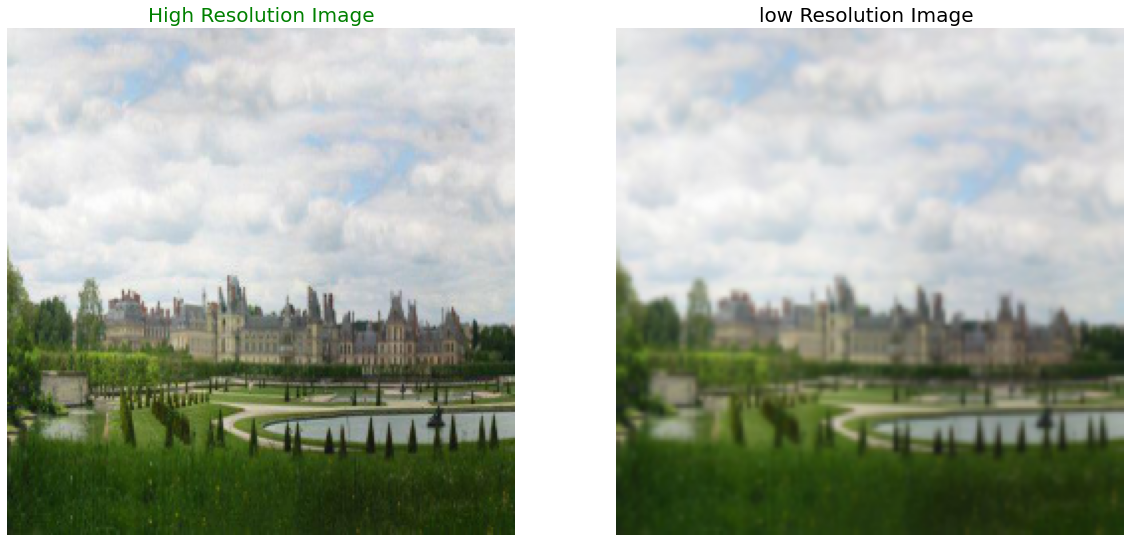

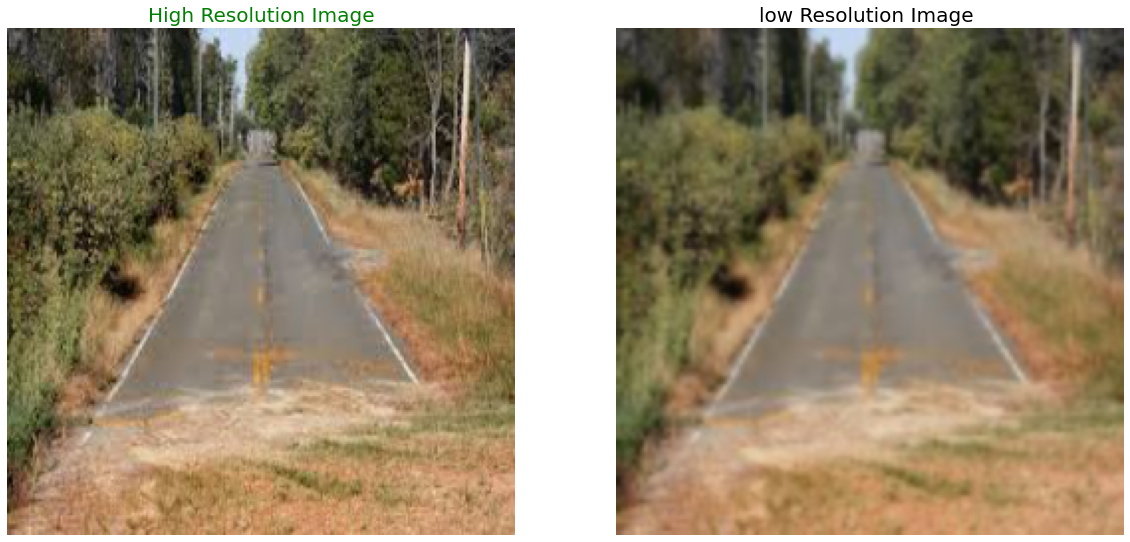

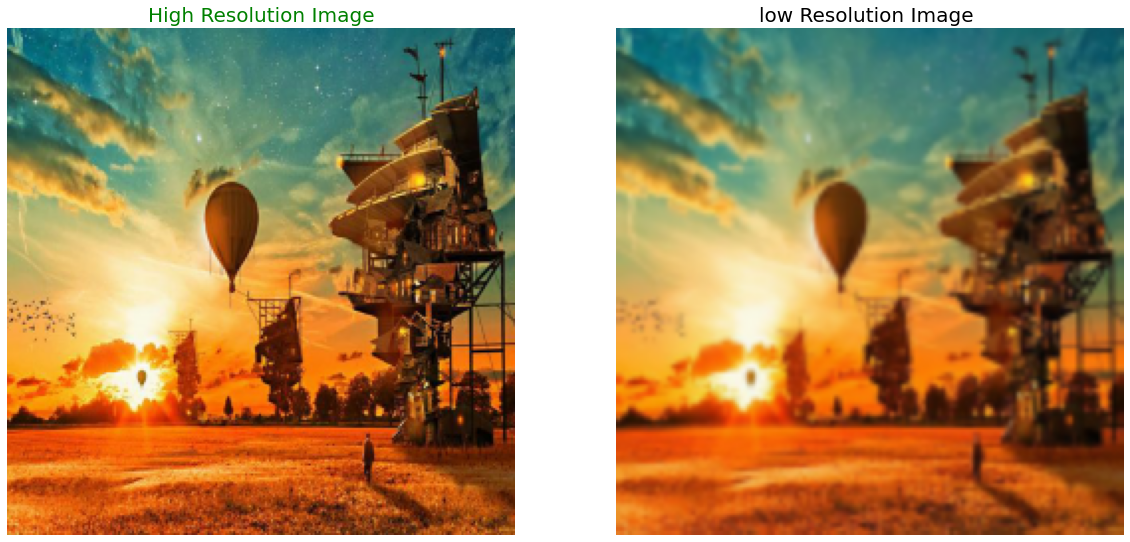

In [39]:
for i in range(5):
    a = np.random.randint(0,855)
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.title('High Resolution Image', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

Разбиваем данные на тренировочную,тестовую и валидационную выборки

In [40]:
def prepare_datasets(high_img, low_img, train_size=700, val_size=130, size=256):
    train_high_image = high_img[:train_size]
    train_low_image = low_img[:train_size]
    train_high_image = np.reshape(train_high_image, (len(train_high_image), size, size, 3))
    train_low_image = np.reshape(train_low_image, (len(train_low_image), size, size, 3))
    
    val_high_image = high_img[train_size:train_size + val_size]
    val_low_image = low_img[train_size:train_size + val_size]
    val_high_image = np.reshape(val_high_image, (len(val_high_image), size, size, 3))
    val_low_image = np.reshape(val_low_image, (len(val_low_image), size, size, 3))
    
    test_high_image = high_img[train_size + val_size:]
    test_low_image = low_img[train_size + val_size:]
    test_high_image = np.reshape(test_high_image, (len(test_high_image), size, size, 3))
    test_low_image = np.reshape(test_low_image, (len(test_low_image), size, size, 3))
    
print("Размер обучающих изображений:", train_high_image.shape)
print("Размер тестовых изображений:", test_high_image.shape)
print("Размер изображений для валидации:", val_high_image.shape)

    return (train_high_image, train_low_image, 
            val_high_image, val_low_image, 
            test_high_image, test_low_image)

train_high_image, train_low_image, val_high_image, val_low_image, test_high_image, test_low_image = prepare_datasets(high_img, low_img)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


Создаем U-Net-подобную модель

In [41]:
def down(filters, kernel_size, apply_batch_normalization=True):
    downsample = tf.keras.Sequential()
    downsample.add(layers.Conv2D(filters, kernel_size, padding='same', strides=2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(layers.LeakyReLU())
    return downsample

def up(filters, kernel_size, apply_dropout=False):
    upsample = tf.keras.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size, padding='same', strides=2))
    if apply_dropout:
        upsample.add(layers.Dropout(0.2))
    upsample.add(layers.LeakyReLU())
    return upsample

def build_model(size):
    inputs = layers.Input(shape=[size, size, 3])

    # Downsampling
    d1 = down(128, (3, 3), False)(inputs)
    d2 = down(128, (3, 3), False)(d1)
    d3 = down(256, (3, 3), True)(d2)
    d4 = down(512, (3, 3), True)(d3)
    d5 = down(512, (3, 3), True)(d4)

    # Upsampling
    u1 = up(512, (3, 3), False)(d5)
    u1 = layers.Concatenate()([u1, d4])
    u2 = up(256, (3, 3), False)(u1)
    u2 = layers.Concatenate()([u2, d3])
    u3 = up(128, (3, 3), False)(u2)
    u3 = layers.Concatenate()([u3, d2])
    u4 = up(128, (3, 3), False)(u3)
    u4 = layers.Concatenate()([u4, d1])

    # Выходной слой
    u5 = up(3, (3, 3), False)(u4)
    u5 = layers.Concatenate()([u5, inputs])  # Skip connection с входом
    output = layers.Conv2D(3, (2, 2), strides=1, padding='same', activation='sigmoid')(u5)

    return tf.keras.Model(inputs=inputs, outputs=output)


model = build_model(SIZE)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_30 (Sequential)      (None, 128, 128, 128 3584        input_4[0][0]                    
__________________________________________________________________________________________________
sequential_31 (Sequential)      (None, 64, 64, 128)  147584      sequential_30[0][0]              
__________________________________________________________________________________________________
sequential_32 (Sequential)      (None, 32, 32, 256)  296192      sequential_31[0][0]              
____________________________________________________________________________________________

Компилируем модель

In [42]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

Обучаем модель

In [43]:
model.fit(train_low_image, train_high_image, epochs = 10, batch_size = 5,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/10
140/140 [==============================] - 7s 46ms/step - loss: 0.1349 - acc: 0.3873 - val_loss: 0.1931 - val_acc: 0.1141
Epoch 2/10
140/140 [==============================] - 6s 44ms/step - loss: 0.0760 - acc: 0.5339 - val_loss: 0.1371 - val_acc: 0.1068
Epoch 3/10
140/140 [==============================] - 6s 44ms/step - loss: 0.0612 - acc: 0.5954 - val_loss: 0.1373 - val_acc: 0.1186
Epoch 4/10
140/140 [==============================] - 6s 44ms/step - loss: 0.0478 - acc: 0.6743 - val_loss: 0.1254 - val_acc: 0.1316
Epoch 5/10
140/140 [==============================] - 6s 44ms/step - loss: 0.0427 - acc: 0.6930 - val_loss: 0.1141 - val_acc: 0.1306
Epoch 6/10
140/140 [==============================] - 6s 44ms/step - loss: 0.0369 - acc: 0.7443 - val_loss: 0.1105 - val_acc: 0.1913
Epoch 7/10
140/140 [==============================] - 6s 44ms/step - loss: 0.0352 - acc: 0.7276 - val_loss: 0.1069 - val_acc: 0.1415
Epoch 8/10
140/140 [==============================] - 6s 44ms/step - 

Выбираем случайные изображения из тестового набора и отображаем по три картинки для каждого: оригинальное изображение высокого разрешения, изображение низкого разрешения и предсказанное моделью изображение высокого разрешения

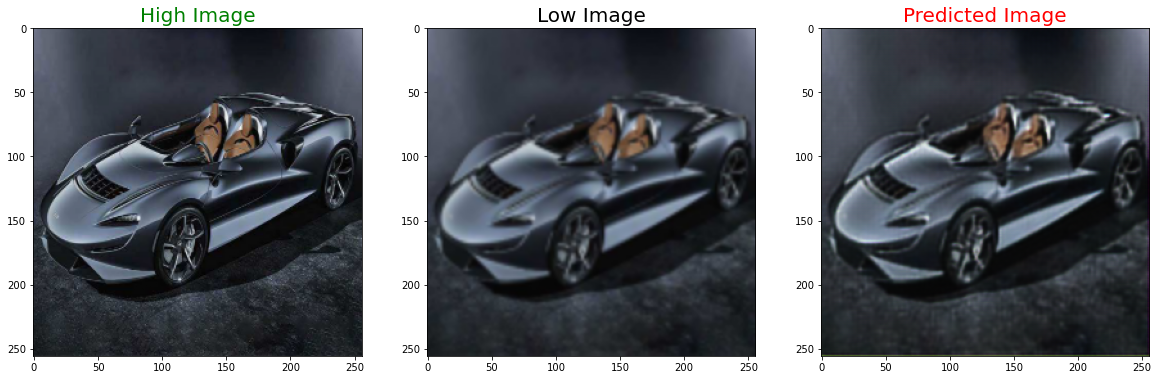

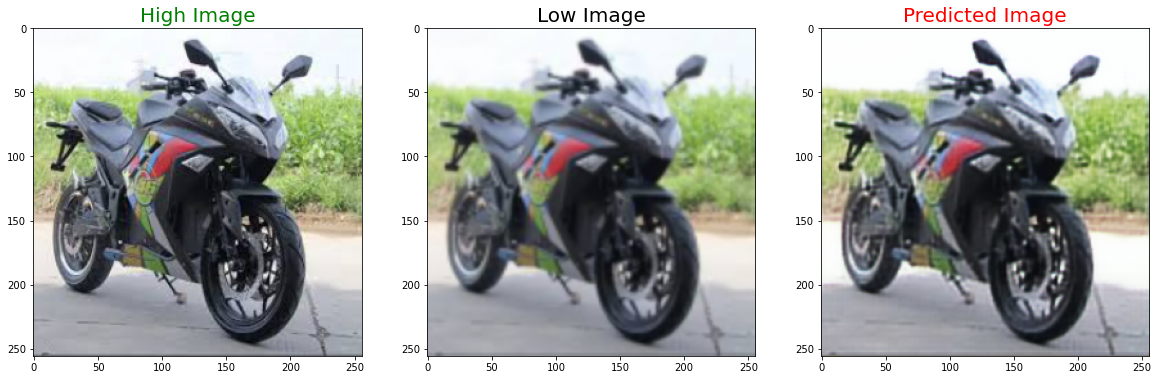

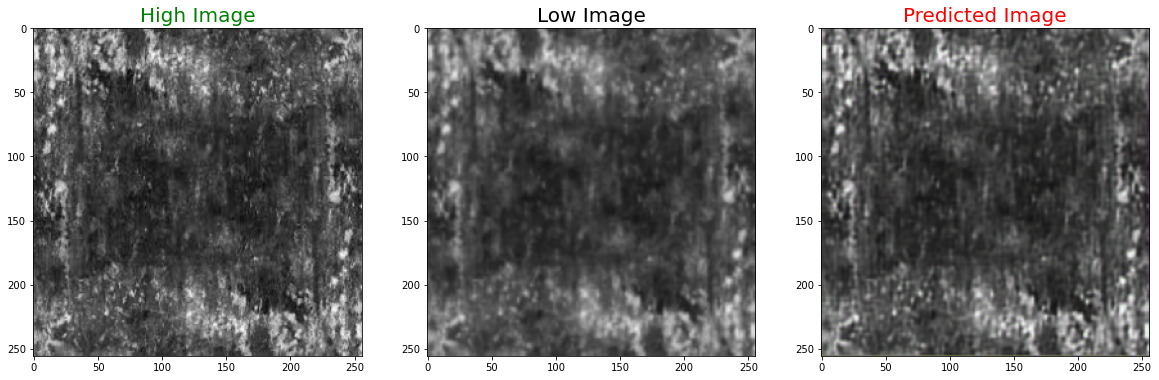

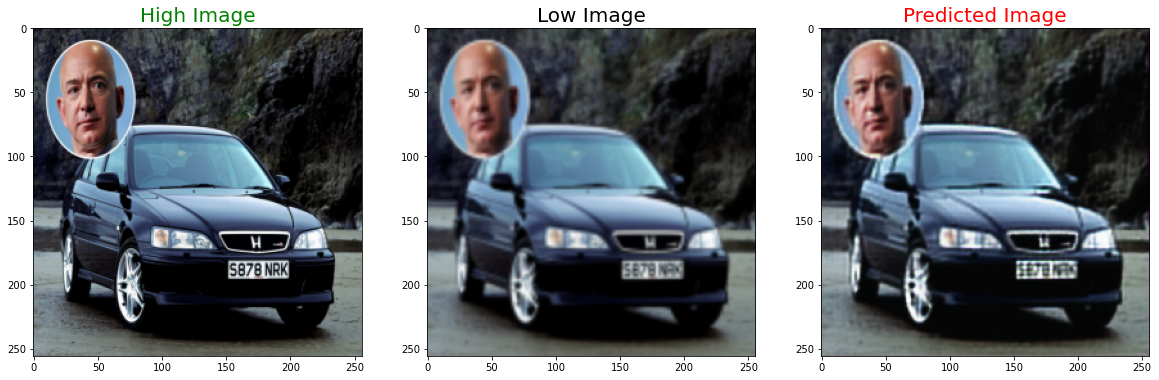

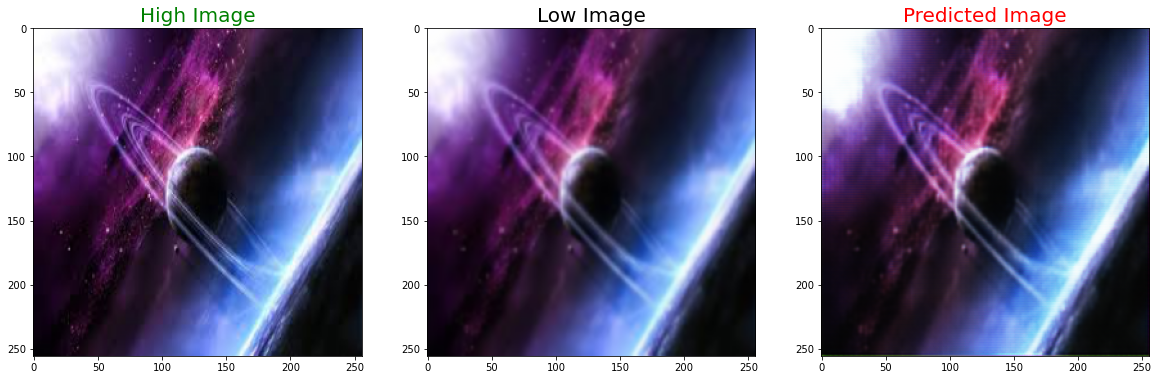

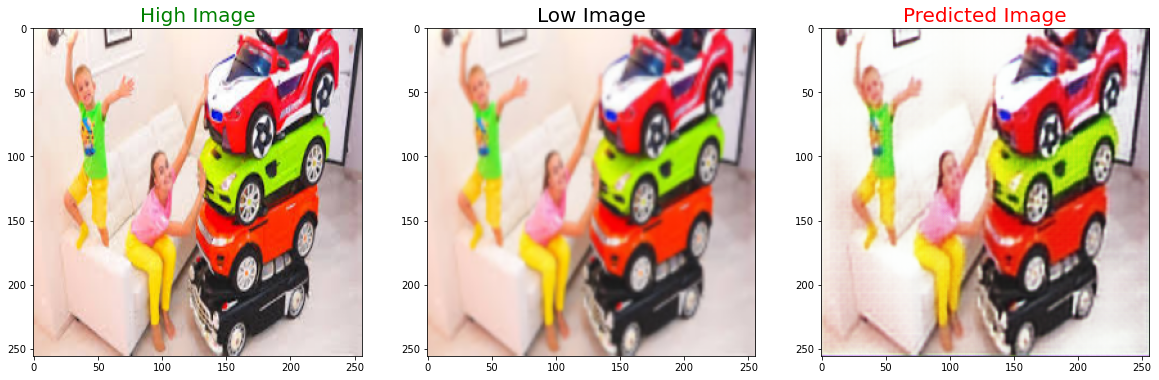

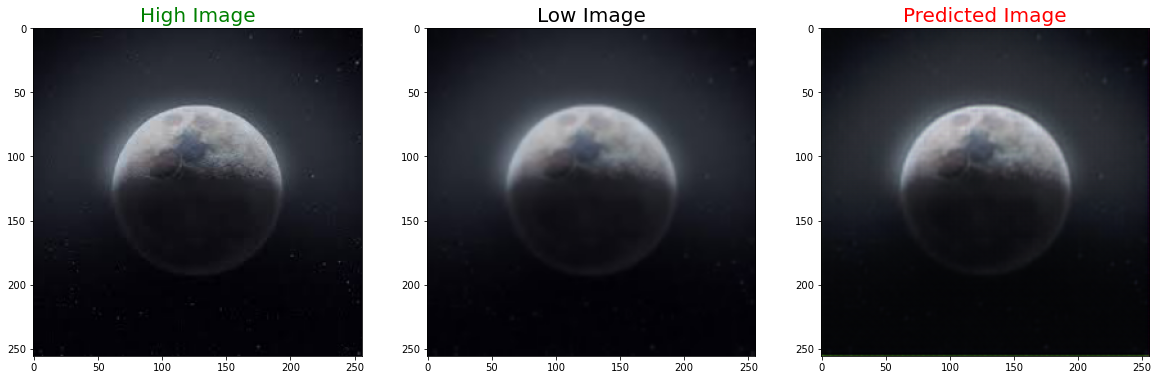

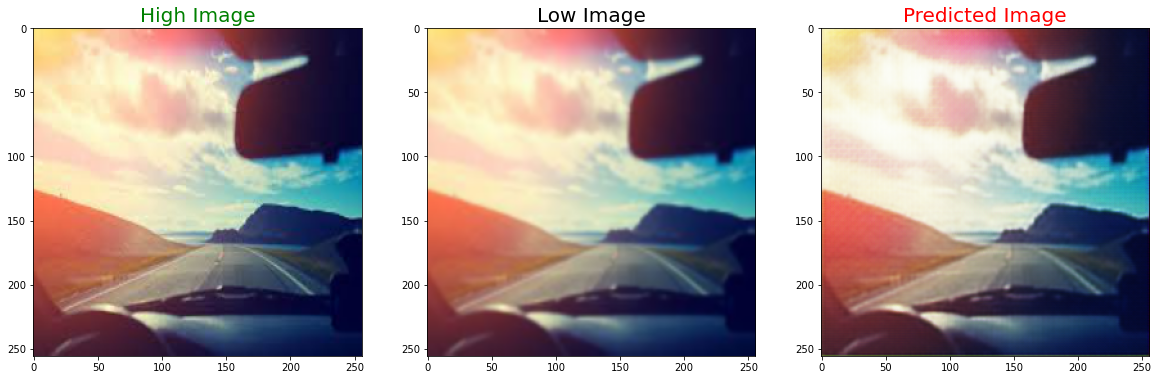

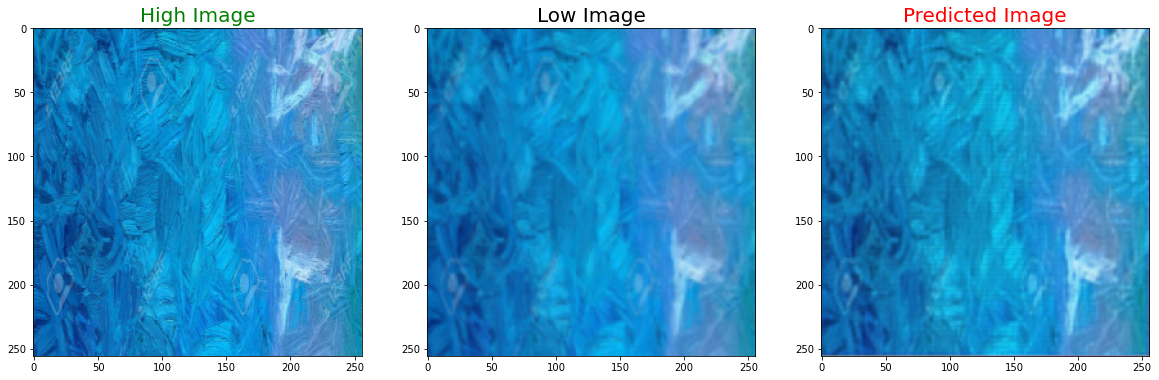

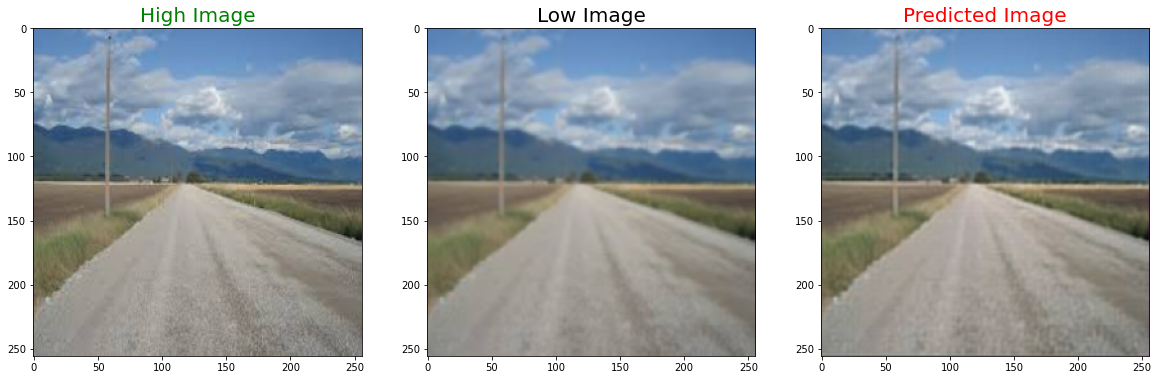

In [44]:
def plot_images(high, low, predicted):
    plt.figure(figsize=(20, 25))

    plt.subplot(1, 3, 1)
    plt.title('High Image', color='green', fontsize=20)
    plt.imshow(high)

    plt.subplot(1, 3, 2)
    plt.title('Low Image', color='black', fontsize=20)
    plt.imshow(low)

    plt.subplot(1, 3, 3)
    plt.title('Predicted Image', color='red', fontsize=20)
    plt.imshow(predicted)
    plt.show()

num_samples = 10  
random_indices = random.sample(range(len(test_low_image)), num_samples)

for idx in random_indices:
    predicted = np.clip(
        model.predict(test_low_image[idx].reshape(1, SIZE, SIZE, 3)), 0.0, 1.0
    ).reshape(SIZE, SIZE, 3)
    plot_images(test_high_image[idx], test_low_image[idx], predicted)

Сохраним модель

In [45]:
model.save("final_model.h5")